[View in Colaboratory](https://colab.research.google.com/github/sungreong/GAN/blob/master/DCGAN.ipynb)

## https://angrypark.github.io/DCGAN-paper-reading/

## https://github.com/sungreong/Keras-GAN/blob/master/dcgan/dcgan.py

The training images have been scaled to a range of [-1, 1].  

The activation function used is LeakyRELU(for both the generator and discriminator) with 0.2 as the alpha(slope) value except for the 

last layer of the generator which uses tanh as the activation function.  

There are no Fully connected layers used.  

Instead of Max-pooling, strided convolutions are used in the discriminator.  

For the generator, Upsampling followed by a convolutional layer is used to increase the resolution of the image.  

The optimizer used is Adam.  

A batch size of 128 is used to the train the generator and the discriminator  

In [0]:
from __future__ import print_function , division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D , Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam


In [0]:
import matplotlib.pyplot as plt

import sys
import numpy as np
import os


In [0]:
class DCGAN():
    def __init__(self):
        self.img_rows = 28 
        self.img_cols = 28
        self.channels = 1

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

         
    def build_generator(self):

        noise_shape = (100,)
        
        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_shape=noise_shape))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8)) 
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(1, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

       
        img_shape = (self.img_rows, self.img_cols, self.channels)
        
        model = Sequential()
        
        ## Discriminator에서는 모든 pooling layers를 strided convolutions 로 바꾼다.
        ## Generator와 Discriminator에 batch-normalization을 사용한다
        ##  그러나 모든 layer에 다 적용하면 sample oscillation과 model instability의 문제가 발생하여 Discriminator input layer에는 적용하지 않았다고 한다.
        ## Discriminator에서는 모든 활성화 함수를 LeakyRelu를 쓴다.
        
        ## called transposed convolution. Instead of fractionally-strided convolution as suggested in DCGAN
        
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            # Sample noise and generate a half batch of new images
            noise = np.random.normal(0, 1, (half_batch, 100))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, np.ones((batch_size, 1)))

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        #fig.suptitle("DCGAN: Generated digits", fontsize=12)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        if not os.path.exists("./images"):
            os.makedirs("./images")
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()




In [36]:
%%time

if __name__ == '__main__':
    dcgan = DCGAN()
    dcgan.train(epochs=4000, batch_size=32, save_interval=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_28 (Dropout)         (None, 8, 8, 64)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.916218, acc.: 34.38%] [G loss: 0.786627]
1 [D loss: 0.683906, acc.: 56.25%] [G loss: 0.826510]
2 [D loss: 0.613418, acc.: 62.50%] [G loss: 0.931055]
3 [D loss: 0.476317, acc.: 81.25%] [G loss: 0.808027]
4 [D loss: 0.512299, acc.: 75.00%] [G loss: 0.907506]
5 [D loss: 0.374197, acc.: 90.62%] [G loss: 1.359673]
6 [D loss: 0.333778, acc.: 90.62%] [G loss: 1.295575]
7 [D loss: 0.314982, acc.: 87.50%] [G loss: 1.319186]
8 [D loss: 0.364275, acc.: 87.50%] [G loss: 1.482754]
9 [D loss: 0.316566, acc.: 90.62%] [G loss: 1.416956]
10 [D loss: 0.258322, acc.: 100.00%] [G loss: 1.527956]
11 [D loss: 0.326561, acc.: 87.50%] [G loss: 1.873163]
12 [D loss: 0.291813, acc.: 90.62%] [G loss: 1.973686]
13 [D loss: 0.282394, acc.: 84.38%] [G loss: 1.797666]
14 [D loss: 0.192880, acc.: 100.00%] [G loss: 1.866074]
15 [D loss: 0.279396, acc.: 93.75%] [G loss: 1.614272]
16 [D loss: 0.229541, acc.: 90.62%] [G loss: 1.814074]
17 [D loss: 0.172858, acc.: 96.88%] [G loss: 2.153530]
18 [D loss: 0.2237

113 [D loss: 1.013700, acc.: 46.88%] [G loss: 1.682231]
114 [D loss: 1.192420, acc.: 34.38%] [G loss: 1.288516]
115 [D loss: 0.936441, acc.: 50.00%] [G loss: 0.885286]
116 [D loss: 1.007173, acc.: 50.00%] [G loss: 1.160907]
117 [D loss: 1.022846, acc.: 50.00%] [G loss: 1.773519]
118 [D loss: 1.067539, acc.: 43.75%] [G loss: 1.715193]
119 [D loss: 1.119856, acc.: 31.25%] [G loss: 1.266605]
120 [D loss: 0.991804, acc.: 40.62%] [G loss: 1.580844]
121 [D loss: 0.863111, acc.: 46.88%] [G loss: 1.970643]
122 [D loss: 0.888290, acc.: 46.88%] [G loss: 1.193770]
123 [D loss: 0.721850, acc.: 62.50%] [G loss: 1.613645]
124 [D loss: 1.199441, acc.: 50.00%] [G loss: 1.003009]
125 [D loss: 0.885297, acc.: 53.12%] [G loss: 1.467808]
126 [D loss: 1.255421, acc.: 40.62%] [G loss: 1.608400]
127 [D loss: 0.753068, acc.: 59.38%] [G loss: 1.669007]
128 [D loss: 0.933681, acc.: 53.12%] [G loss: 1.563179]
129 [D loss: 1.188351, acc.: 28.12%] [G loss: 1.587121]
130 [D loss: 0.980397, acc.: 50.00%] [G loss: 1.

225 [D loss: 0.720509, acc.: 56.25%] [G loss: 1.441044]
226 [D loss: 1.041848, acc.: 34.38%] [G loss: 1.217612]
227 [D loss: 0.824504, acc.: 46.88%] [G loss: 0.908036]
228 [D loss: 0.895650, acc.: 46.88%] [G loss: 0.902700]
229 [D loss: 0.551955, acc.: 68.75%] [G loss: 1.277624]
230 [D loss: 0.443488, acc.: 81.25%] [G loss: 1.374604]
231 [D loss: 0.854926, acc.: 46.88%] [G loss: 1.001446]
232 [D loss: 0.890697, acc.: 37.50%] [G loss: 1.019723]
233 [D loss: 0.729840, acc.: 53.12%] [G loss: 1.307815]
234 [D loss: 0.776148, acc.: 53.12%] [G loss: 1.449392]
235 [D loss: 0.813444, acc.: 53.12%] [G loss: 1.233486]
236 [D loss: 0.955808, acc.: 50.00%] [G loss: 1.178759]
237 [D loss: 0.874264, acc.: 46.88%] [G loss: 0.986931]
238 [D loss: 0.866138, acc.: 43.75%] [G loss: 0.984090]
239 [D loss: 0.725273, acc.: 53.12%] [G loss: 1.094733]
240 [D loss: 0.640921, acc.: 59.38%] [G loss: 0.903615]
241 [D loss: 0.784661, acc.: 53.12%] [G loss: 1.257919]
242 [D loss: 0.651314, acc.: 62.50%] [G loss: 1.

337 [D loss: 0.676684, acc.: 59.38%] [G loss: 0.944289]
338 [D loss: 0.901226, acc.: 43.75%] [G loss: 1.120814]
339 [D loss: 0.774250, acc.: 56.25%] [G loss: 1.040184]
340 [D loss: 0.558864, acc.: 75.00%] [G loss: 1.045405]
341 [D loss: 0.673344, acc.: 59.38%] [G loss: 1.163886]
342 [D loss: 0.863775, acc.: 50.00%] [G loss: 0.832959]
343 [D loss: 0.877182, acc.: 46.88%] [G loss: 1.142639]
344 [D loss: 0.759172, acc.: 59.38%] [G loss: 1.297026]
345 [D loss: 0.724121, acc.: 59.38%] [G loss: 1.300551]
346 [D loss: 0.740048, acc.: 59.38%] [G loss: 1.223567]
347 [D loss: 0.820251, acc.: 50.00%] [G loss: 1.433411]
348 [D loss: 0.647657, acc.: 59.38%] [G loss: 0.847773]
349 [D loss: 0.578290, acc.: 75.00%] [G loss: 1.193091]
350 [D loss: 0.745005, acc.: 53.12%] [G loss: 1.300200]
351 [D loss: 0.701038, acc.: 68.75%] [G loss: 1.193777]
352 [D loss: 0.725926, acc.: 56.25%] [G loss: 1.047036]
353 [D loss: 0.771724, acc.: 53.12%] [G loss: 1.246892]
354 [D loss: 0.579823, acc.: 65.62%] [G loss: 1.

451 [D loss: 0.828141, acc.: 40.62%] [G loss: 1.185561]
452 [D loss: 0.671939, acc.: 62.50%] [G loss: 1.149540]
453 [D loss: 0.847366, acc.: 43.75%] [G loss: 1.186941]
454 [D loss: 0.756570, acc.: 46.88%] [G loss: 0.947388]
455 [D loss: 0.694212, acc.: 56.25%] [G loss: 0.972528]
456 [D loss: 0.957033, acc.: 31.25%] [G loss: 1.146638]
457 [D loss: 0.690617, acc.: 50.00%] [G loss: 1.003493]
458 [D loss: 0.752496, acc.: 53.12%] [G loss: 1.273144]
459 [D loss: 0.576638, acc.: 59.38%] [G loss: 1.258889]
460 [D loss: 0.821546, acc.: 50.00%] [G loss: 1.130738]
461 [D loss: 0.751786, acc.: 50.00%] [G loss: 0.936825]
462 [D loss: 0.719099, acc.: 59.38%] [G loss: 1.000243]
463 [D loss: 0.790382, acc.: 59.38%] [G loss: 1.203838]
464 [D loss: 0.644196, acc.: 65.62%] [G loss: 1.137935]
465 [D loss: 0.536192, acc.: 71.88%] [G loss: 1.082985]
466 [D loss: 0.813188, acc.: 43.75%] [G loss: 0.950826]
467 [D loss: 0.683557, acc.: 62.50%] [G loss: 1.122046]
468 [D loss: 0.690558, acc.: 62.50%] [G loss: 1.

563 [D loss: 0.729411, acc.: 62.50%] [G loss: 1.123108]
564 [D loss: 0.722231, acc.: 53.12%] [G loss: 1.059220]
565 [D loss: 0.634396, acc.: 59.38%] [G loss: 1.092143]
566 [D loss: 0.595401, acc.: 65.62%] [G loss: 1.087350]
567 [D loss: 0.590942, acc.: 68.75%] [G loss: 1.136260]
568 [D loss: 0.756222, acc.: 56.25%] [G loss: 1.179654]
569 [D loss: 0.749790, acc.: 59.38%] [G loss: 1.219550]
570 [D loss: 0.609851, acc.: 68.75%] [G loss: 0.957724]
571 [D loss: 0.681372, acc.: 65.62%] [G loss: 1.054627]
572 [D loss: 0.739158, acc.: 56.25%] [G loss: 0.980972]
573 [D loss: 0.707023, acc.: 56.25%] [G loss: 1.313570]
574 [D loss: 0.742763, acc.: 56.25%] [G loss: 1.212317]
575 [D loss: 0.707647, acc.: 65.62%] [G loss: 1.305898]
576 [D loss: 0.708972, acc.: 59.38%] [G loss: 1.160300]
577 [D loss: 0.691315, acc.: 59.38%] [G loss: 1.296337]
578 [D loss: 0.891572, acc.: 40.62%] [G loss: 1.332798]
579 [D loss: 0.765424, acc.: 56.25%] [G loss: 0.953497]
580 [D loss: 0.912628, acc.: 46.88%] [G loss: 0.

675 [D loss: 0.585287, acc.: 75.00%] [G loss: 1.030934]
676 [D loss: 0.688977, acc.: 62.50%] [G loss: 1.010026]
677 [D loss: 0.613600, acc.: 62.50%] [G loss: 1.137710]
678 [D loss: 0.679285, acc.: 59.38%] [G loss: 1.251089]
679 [D loss: 0.596785, acc.: 71.88%] [G loss: 1.262409]
680 [D loss: 0.686104, acc.: 59.38%] [G loss: 1.267341]
681 [D loss: 0.717334, acc.: 62.50%] [G loss: 1.163590]
682 [D loss: 0.781816, acc.: 56.25%] [G loss: 1.665659]
683 [D loss: 0.615788, acc.: 62.50%] [G loss: 1.243557]
684 [D loss: 0.790124, acc.: 50.00%] [G loss: 1.197242]
685 [D loss: 0.559394, acc.: 71.88%] [G loss: 1.233804]
686 [D loss: 0.726979, acc.: 56.25%] [G loss: 1.103423]
687 [D loss: 0.739242, acc.: 53.12%] [G loss: 1.133833]
688 [D loss: 0.728682, acc.: 50.00%] [G loss: 0.966322]
689 [D loss: 0.677999, acc.: 62.50%] [G loss: 1.175914]
690 [D loss: 0.598755, acc.: 68.75%] [G loss: 1.188804]
691 [D loss: 0.697138, acc.: 68.75%] [G loss: 0.891046]
692 [D loss: 0.709425, acc.: 59.38%] [G loss: 0.

787 [D loss: 0.820522, acc.: 46.88%] [G loss: 1.060512]
788 [D loss: 0.721014, acc.: 65.62%] [G loss: 1.339496]
789 [D loss: 0.590277, acc.: 68.75%] [G loss: 1.167598]
790 [D loss: 0.827113, acc.: 50.00%] [G loss: 1.271316]
791 [D loss: 0.604938, acc.: 65.62%] [G loss: 1.366336]
792 [D loss: 0.783720, acc.: 43.75%] [G loss: 0.997228]
793 [D loss: 0.652794, acc.: 68.75%] [G loss: 1.279610]
794 [D loss: 0.667071, acc.: 62.50%] [G loss: 1.142958]
795 [D loss: 0.641330, acc.: 62.50%] [G loss: 1.130399]
796 [D loss: 0.648593, acc.: 65.62%] [G loss: 0.824229]
797 [D loss: 0.681597, acc.: 50.00%] [G loss: 0.938199]
798 [D loss: 0.680531, acc.: 56.25%] [G loss: 0.964928]
799 [D loss: 0.475428, acc.: 84.38%] [G loss: 1.289050]
800 [D loss: 0.697301, acc.: 59.38%] [G loss: 0.999283]
801 [D loss: 0.786372, acc.: 50.00%] [G loss: 1.114902]
802 [D loss: 0.508814, acc.: 71.88%] [G loss: 1.080247]
803 [D loss: 0.645146, acc.: 68.75%] [G loss: 1.258906]
804 [D loss: 0.707291, acc.: 62.50%] [G loss: 0.

901 [D loss: 0.875045, acc.: 43.75%] [G loss: 1.107242]
902 [D loss: 0.561888, acc.: 68.75%] [G loss: 1.388631]
903 [D loss: 0.662113, acc.: 65.62%] [G loss: 0.981852]
904 [D loss: 0.664144, acc.: 53.12%] [G loss: 1.285174]
905 [D loss: 0.722410, acc.: 50.00%] [G loss: 1.300368]
906 [D loss: 0.758725, acc.: 46.88%] [G loss: 1.147373]
907 [D loss: 0.633490, acc.: 71.88%] [G loss: 0.958596]
908 [D loss: 0.800494, acc.: 62.50%] [G loss: 1.172879]
909 [D loss: 0.611348, acc.: 62.50%] [G loss: 1.199136]
910 [D loss: 0.734847, acc.: 56.25%] [G loss: 1.382033]
911 [D loss: 0.775690, acc.: 50.00%] [G loss: 1.213082]
912 [D loss: 0.611260, acc.: 62.50%] [G loss: 1.124667]
913 [D loss: 0.698566, acc.: 59.38%] [G loss: 1.191229]
914 [D loss: 0.776757, acc.: 40.62%] [G loss: 1.166890]
915 [D loss: 0.711727, acc.: 59.38%] [G loss: 1.101635]
916 [D loss: 0.855119, acc.: 56.25%] [G loss: 1.042177]
917 [D loss: 0.526266, acc.: 84.38%] [G loss: 1.163895]
918 [D loss: 0.688391, acc.: 59.38%] [G loss: 1.

1013 [D loss: 0.706696, acc.: 56.25%] [G loss: 1.045639]
1014 [D loss: 0.678146, acc.: 56.25%] [G loss: 1.184744]
1015 [D loss: 0.560155, acc.: 71.88%] [G loss: 1.044019]
1016 [D loss: 0.755679, acc.: 46.88%] [G loss: 0.947447]
1017 [D loss: 0.765123, acc.: 50.00%] [G loss: 0.861688]
1018 [D loss: 0.766362, acc.: 46.88%] [G loss: 1.238994]
1019 [D loss: 0.734646, acc.: 56.25%] [G loss: 1.206972]
1020 [D loss: 0.814048, acc.: 34.38%] [G loss: 1.182820]
1021 [D loss: 0.670711, acc.: 59.38%] [G loss: 1.207505]
1022 [D loss: 0.771829, acc.: 46.88%] [G loss: 1.256610]
1023 [D loss: 0.572899, acc.: 71.88%] [G loss: 1.338165]
1024 [D loss: 0.831380, acc.: 43.75%] [G loss: 1.338750]
1025 [D loss: 0.814877, acc.: 46.88%] [G loss: 1.374452]
1026 [D loss: 0.557979, acc.: 71.88%] [G loss: 1.144375]
1027 [D loss: 0.648424, acc.: 68.75%] [G loss: 1.262936]
1028 [D loss: 0.557715, acc.: 68.75%] [G loss: 1.352260]
1029 [D loss: 0.585781, acc.: 71.88%] [G loss: 1.470364]
1030 [D loss: 0.659088, acc.: 5

1125 [D loss: 0.702446, acc.: 59.38%] [G loss: 1.194890]
1126 [D loss: 0.601603, acc.: 65.62%] [G loss: 1.120974]
1127 [D loss: 0.707577, acc.: 53.12%] [G loss: 1.109822]
1128 [D loss: 0.755204, acc.: 37.50%] [G loss: 1.116230]
1129 [D loss: 0.688653, acc.: 59.38%] [G loss: 1.289538]
1130 [D loss: 0.585351, acc.: 59.38%] [G loss: 1.233129]
1131 [D loss: 0.818730, acc.: 37.50%] [G loss: 1.196771]
1132 [D loss: 0.694952, acc.: 53.12%] [G loss: 1.165754]
1133 [D loss: 0.640858, acc.: 65.62%] [G loss: 1.163178]
1134 [D loss: 0.641750, acc.: 59.38%] [G loss: 1.183309]
1135 [D loss: 0.611275, acc.: 65.62%] [G loss: 1.221592]
1136 [D loss: 0.727831, acc.: 46.88%] [G loss: 1.038778]
1137 [D loss: 0.975495, acc.: 43.75%] [G loss: 1.174617]
1138 [D loss: 0.605056, acc.: 62.50%] [G loss: 1.026112]
1139 [D loss: 0.728100, acc.: 59.38%] [G loss: 1.022295]
1140 [D loss: 0.648042, acc.: 59.38%] [G loss: 0.890936]
1141 [D loss: 0.631957, acc.: 59.38%] [G loss: 1.030838]
1142 [D loss: 0.722817, acc.: 5

1237 [D loss: 0.545437, acc.: 78.12%] [G loss: 0.878769]
1238 [D loss: 0.622956, acc.: 62.50%] [G loss: 1.261259]
1239 [D loss: 0.648111, acc.: 59.38%] [G loss: 1.065118]
1240 [D loss: 0.725450, acc.: 56.25%] [G loss: 1.137749]
1241 [D loss: 0.746197, acc.: 56.25%] [G loss: 1.274949]
1242 [D loss: 0.629138, acc.: 65.62%] [G loss: 1.164708]
1243 [D loss: 0.749618, acc.: 50.00%] [G loss: 1.067401]
1244 [D loss: 0.716089, acc.: 56.25%] [G loss: 1.121999]
1245 [D loss: 0.877207, acc.: 28.12%] [G loss: 1.084239]
1246 [D loss: 0.689372, acc.: 50.00%] [G loss: 1.240602]
1247 [D loss: 0.688172, acc.: 53.12%] [G loss: 0.987238]
1248 [D loss: 0.788098, acc.: 43.75%] [G loss: 1.031937]
1249 [D loss: 0.598679, acc.: 75.00%] [G loss: 1.061517]
1250 [D loss: 0.780836, acc.: 59.38%] [G loss: 1.215709]
1251 [D loss: 0.839401, acc.: 43.75%] [G loss: 0.888662]
1252 [D loss: 0.470358, acc.: 90.62%] [G loss: 1.236115]
1253 [D loss: 0.721486, acc.: 56.25%] [G loss: 0.941141]
1254 [D loss: 0.631808, acc.: 6

1349 [D loss: 0.625574, acc.: 56.25%] [G loss: 0.960432]
1350 [D loss: 0.784863, acc.: 56.25%] [G loss: 1.078702]
1351 [D loss: 0.763999, acc.: 46.88%] [G loss: 1.080523]
1352 [D loss: 0.762804, acc.: 50.00%] [G loss: 0.977806]
1353 [D loss: 0.627972, acc.: 68.75%] [G loss: 1.029133]
1354 [D loss: 0.624231, acc.: 59.38%] [G loss: 0.868059]
1355 [D loss: 0.603353, acc.: 71.88%] [G loss: 1.127135]
1356 [D loss: 0.755519, acc.: 46.88%] [G loss: 0.996306]
1357 [D loss: 0.622373, acc.: 59.38%] [G loss: 1.050859]
1358 [D loss: 0.786575, acc.: 56.25%] [G loss: 1.057293]
1359 [D loss: 0.827599, acc.: 43.75%] [G loss: 0.893325]
1360 [D loss: 0.757225, acc.: 46.88%] [G loss: 0.869788]
1361 [D loss: 0.710015, acc.: 62.50%] [G loss: 0.946302]
1362 [D loss: 0.867197, acc.: 53.12%] [G loss: 0.941774]
1363 [D loss: 0.718139, acc.: 53.12%] [G loss: 0.926533]
1364 [D loss: 0.702522, acc.: 59.38%] [G loss: 1.007878]
1365 [D loss: 0.563362, acc.: 68.75%] [G loss: 1.248971]
1366 [D loss: 0.680840, acc.: 6

1459 [D loss: 0.935091, acc.: 43.75%] [G loss: 1.196158]
1460 [D loss: 0.721785, acc.: 59.38%] [G loss: 0.919503]
1461 [D loss: 0.580797, acc.: 65.62%] [G loss: 1.104415]
1462 [D loss: 0.844167, acc.: 50.00%] [G loss: 0.799611]
1463 [D loss: 0.663812, acc.: 59.38%] [G loss: 0.979182]
1464 [D loss: 0.841647, acc.: 37.50%] [G loss: 1.105361]
1465 [D loss: 0.748554, acc.: 65.62%] [G loss: 1.109160]
1466 [D loss: 0.681639, acc.: 56.25%] [G loss: 0.932153]
1467 [D loss: 0.595872, acc.: 65.62%] [G loss: 0.963819]
1468 [D loss: 0.677952, acc.: 62.50%] [G loss: 0.964265]
1469 [D loss: 0.704733, acc.: 59.38%] [G loss: 1.276438]
1470 [D loss: 0.654473, acc.: 68.75%] [G loss: 0.893625]
1471 [D loss: 0.834787, acc.: 37.50%] [G loss: 1.041029]
1472 [D loss: 0.675074, acc.: 62.50%] [G loss: 0.946731]
1473 [D loss: 0.624811, acc.: 62.50%] [G loss: 0.885426]
1474 [D loss: 0.541455, acc.: 78.12%] [G loss: 1.018230]
1475 [D loss: 0.661730, acc.: 56.25%] [G loss: 1.131902]
1476 [D loss: 0.814529, acc.: 4

1571 [D loss: 0.790871, acc.: 46.88%] [G loss: 1.135510]
1572 [D loss: 0.628862, acc.: 65.62%] [G loss: 0.852214]
1573 [D loss: 0.777980, acc.: 43.75%] [G loss: 1.151938]
1574 [D loss: 0.634391, acc.: 65.62%] [G loss: 1.204270]
1575 [D loss: 0.642890, acc.: 62.50%] [G loss: 1.005920]
1576 [D loss: 0.626993, acc.: 68.75%] [G loss: 0.964969]
1577 [D loss: 0.712121, acc.: 53.12%] [G loss: 0.783231]
1578 [D loss: 0.745541, acc.: 53.12%] [G loss: 0.919837]
1579 [D loss: 0.598496, acc.: 65.62%] [G loss: 0.968997]
1580 [D loss: 0.778520, acc.: 53.12%] [G loss: 1.066634]
1581 [D loss: 0.630926, acc.: 68.75%] [G loss: 1.037845]
1582 [D loss: 0.608973, acc.: 75.00%] [G loss: 0.989747]
1583 [D loss: 0.607691, acc.: 65.62%] [G loss: 0.905879]
1584 [D loss: 0.712887, acc.: 53.12%] [G loss: 1.057640]
1585 [D loss: 0.657688, acc.: 59.38%] [G loss: 1.088050]
1586 [D loss: 0.679266, acc.: 68.75%] [G loss: 1.052744]
1587 [D loss: 0.585836, acc.: 62.50%] [G loss: 0.809285]
1588 [D loss: 0.749146, acc.: 5

1683 [D loss: 0.681833, acc.: 56.25%] [G loss: 1.019692]
1684 [D loss: 0.781512, acc.: 53.12%] [G loss: 1.072387]
1685 [D loss: 0.609699, acc.: 65.62%] [G loss: 0.971568]
1686 [D loss: 0.853504, acc.: 34.38%] [G loss: 0.994226]
1687 [D loss: 0.707869, acc.: 53.12%] [G loss: 0.734455]
1688 [D loss: 0.676945, acc.: 46.88%] [G loss: 0.946879]
1689 [D loss: 0.755007, acc.: 46.88%] [G loss: 1.055391]
1690 [D loss: 0.809480, acc.: 28.12%] [G loss: 1.118489]
1691 [D loss: 0.685889, acc.: 56.25%] [G loss: 1.129022]
1692 [D loss: 0.753701, acc.: 43.75%] [G loss: 1.091363]
1693 [D loss: 0.567721, acc.: 78.12%] [G loss: 0.944873]
1694 [D loss: 0.690554, acc.: 56.25%] [G loss: 0.817947]
1695 [D loss: 0.857014, acc.: 37.50%] [G loss: 0.848025]
1696 [D loss: 0.656723, acc.: 59.38%] [G loss: 1.017494]
1697 [D loss: 0.683273, acc.: 62.50%] [G loss: 0.934242]
1698 [D loss: 0.725504, acc.: 50.00%] [G loss: 0.871830]
1699 [D loss: 0.781436, acc.: 50.00%] [G loss: 0.954093]
1700 [D loss: 0.682775, acc.: 5

1795 [D loss: 0.652842, acc.: 71.88%] [G loss: 0.822731]
1796 [D loss: 0.700535, acc.: 59.38%] [G loss: 0.814730]
1797 [D loss: 0.583553, acc.: 68.75%] [G loss: 1.353678]
1798 [D loss: 0.696699, acc.: 62.50%] [G loss: 0.875866]
1799 [D loss: 0.687601, acc.: 56.25%] [G loss: 1.005075]
1800 [D loss: 0.769993, acc.: 56.25%] [G loss: 0.854927]
1801 [D loss: 0.664426, acc.: 56.25%] [G loss: 0.838343]
1802 [D loss: 0.865664, acc.: 40.62%] [G loss: 1.319796]
1803 [D loss: 0.776456, acc.: 46.88%] [G loss: 1.070564]
1804 [D loss: 0.677867, acc.: 56.25%] [G loss: 1.163020]
1805 [D loss: 0.567162, acc.: 71.88%] [G loss: 1.137982]
1806 [D loss: 0.610666, acc.: 59.38%] [G loss: 1.141879]
1807 [D loss: 0.709604, acc.: 62.50%] [G loss: 0.907864]
1808 [D loss: 0.769169, acc.: 43.75%] [G loss: 1.062545]
1809 [D loss: 0.678622, acc.: 59.38%] [G loss: 0.997289]
1810 [D loss: 0.750009, acc.: 53.12%] [G loss: 0.823445]
1811 [D loss: 0.770415, acc.: 40.62%] [G loss: 0.803946]
1812 [D loss: 0.650370, acc.: 5

1905 [D loss: 0.677947, acc.: 59.38%] [G loss: 1.166698]
1906 [D loss: 0.672395, acc.: 53.12%] [G loss: 1.041430]
1907 [D loss: 0.640427, acc.: 59.38%] [G loss: 0.878100]
1908 [D loss: 0.721917, acc.: 62.50%] [G loss: 1.152433]
1909 [D loss: 0.731735, acc.: 56.25%] [G loss: 1.092860]
1910 [D loss: 0.694847, acc.: 62.50%] [G loss: 0.971752]
1911 [D loss: 0.667880, acc.: 62.50%] [G loss: 1.120182]
1912 [D loss: 0.636488, acc.: 59.38%] [G loss: 1.158903]
1913 [D loss: 0.577223, acc.: 68.75%] [G loss: 0.979788]
1914 [D loss: 0.699303, acc.: 65.62%] [G loss: 0.912302]
1915 [D loss: 0.702661, acc.: 62.50%] [G loss: 1.012240]
1916 [D loss: 0.545697, acc.: 75.00%] [G loss: 1.007858]
1917 [D loss: 0.644097, acc.: 68.75%] [G loss: 0.933804]
1918 [D loss: 0.656782, acc.: 65.62%] [G loss: 1.080819]
1919 [D loss: 0.666632, acc.: 46.88%] [G loss: 1.015787]
1920 [D loss: 0.757129, acc.: 59.38%] [G loss: 1.051380]
1921 [D loss: 0.768574, acc.: 50.00%] [G loss: 0.979032]
1922 [D loss: 0.797217, acc.: 5

2017 [D loss: 0.646760, acc.: 62.50%] [G loss: 0.940657]
2018 [D loss: 0.617780, acc.: 68.75%] [G loss: 0.868747]
2019 [D loss: 0.676997, acc.: 62.50%] [G loss: 0.924574]
2020 [D loss: 0.697047, acc.: 56.25%] [G loss: 1.108242]
2021 [D loss: 0.702032, acc.: 59.38%] [G loss: 1.003073]
2022 [D loss: 0.644385, acc.: 56.25%] [G loss: 0.905454]
2023 [D loss: 0.691291, acc.: 62.50%] [G loss: 0.979400]
2024 [D loss: 0.601131, acc.: 81.25%] [G loss: 1.144348]
2025 [D loss: 0.653292, acc.: 71.88%] [G loss: 0.958032]
2026 [D loss: 0.637972, acc.: 65.62%] [G loss: 0.913273]
2027 [D loss: 0.749589, acc.: 56.25%] [G loss: 1.048532]
2028 [D loss: 0.622055, acc.: 65.62%] [G loss: 0.832986]
2029 [D loss: 0.677713, acc.: 59.38%] [G loss: 1.049883]
2030 [D loss: 0.679653, acc.: 56.25%] [G loss: 0.970763]
2031 [D loss: 0.627675, acc.: 65.62%] [G loss: 0.855881]
2032 [D loss: 0.727587, acc.: 56.25%] [G loss: 0.714988]
2033 [D loss: 0.680934, acc.: 62.50%] [G loss: 0.850445]
2034 [D loss: 0.701389, acc.: 5

2129 [D loss: 0.676752, acc.: 56.25%] [G loss: 0.860624]
2130 [D loss: 0.672610, acc.: 56.25%] [G loss: 1.141058]
2131 [D loss: 0.736138, acc.: 53.12%] [G loss: 0.904789]
2132 [D loss: 0.730667, acc.: 53.12%] [G loss: 1.016982]
2133 [D loss: 0.590215, acc.: 62.50%] [G loss: 0.847177]
2134 [D loss: 0.647016, acc.: 62.50%] [G loss: 0.802906]
2135 [D loss: 0.662884, acc.: 59.38%] [G loss: 0.823196]
2136 [D loss: 0.783426, acc.: 40.62%] [G loss: 0.949055]
2137 [D loss: 0.583932, acc.: 78.12%] [G loss: 1.004002]
2138 [D loss: 0.618513, acc.: 71.88%] [G loss: 0.959321]
2139 [D loss: 0.667646, acc.: 65.62%] [G loss: 0.863437]
2140 [D loss: 0.691627, acc.: 59.38%] [G loss: 0.877194]
2141 [D loss: 0.706759, acc.: 50.00%] [G loss: 0.925554]
2142 [D loss: 0.766384, acc.: 53.12%] [G loss: 0.981691]
2143 [D loss: 0.716812, acc.: 56.25%] [G loss: 0.844557]
2144 [D loss: 0.573710, acc.: 75.00%] [G loss: 1.036525]
2145 [D loss: 0.566657, acc.: 68.75%] [G loss: 1.044986]
2146 [D loss: 0.697299, acc.: 6

2241 [D loss: 0.689105, acc.: 53.12%] [G loss: 0.985151]
2242 [D loss: 0.625272, acc.: 59.38%] [G loss: 0.860186]
2243 [D loss: 0.808442, acc.: 34.38%] [G loss: 0.886394]
2244 [D loss: 0.658810, acc.: 71.88%] [G loss: 1.127594]
2245 [D loss: 0.660415, acc.: 59.38%] [G loss: 1.011571]
2246 [D loss: 0.791793, acc.: 46.88%] [G loss: 1.035705]
2247 [D loss: 0.673114, acc.: 43.75%] [G loss: 1.007720]
2248 [D loss: 0.595614, acc.: 65.62%] [G loss: 0.935677]
2249 [D loss: 0.590464, acc.: 71.88%] [G loss: 0.862427]
2250 [D loss: 0.674095, acc.: 65.62%] [G loss: 1.140001]
2251 [D loss: 0.608083, acc.: 71.88%] [G loss: 1.080173]
2252 [D loss: 0.568194, acc.: 75.00%] [G loss: 1.075475]
2253 [D loss: 0.672385, acc.: 56.25%] [G loss: 0.987421]
2254 [D loss: 0.717204, acc.: 62.50%] [G loss: 0.844423]
2255 [D loss: 0.635838, acc.: 71.88%] [G loss: 0.999405]
2256 [D loss: 0.609306, acc.: 71.88%] [G loss: 1.115899]
2257 [D loss: 0.828290, acc.: 43.75%] [G loss: 0.878599]
2258 [D loss: 0.603246, acc.: 6

2351 [D loss: 0.674169, acc.: 46.88%] [G loss: 0.888048]
2352 [D loss: 0.843663, acc.: 28.12%] [G loss: 1.001264]
2353 [D loss: 0.654892, acc.: 56.25%] [G loss: 0.837296]
2354 [D loss: 0.739280, acc.: 50.00%] [G loss: 0.812934]
2355 [D loss: 0.740786, acc.: 56.25%] [G loss: 0.982160]
2356 [D loss: 0.629814, acc.: 65.62%] [G loss: 1.076365]
2357 [D loss: 0.759089, acc.: 43.75%] [G loss: 1.063799]
2358 [D loss: 0.817867, acc.: 40.62%] [G loss: 1.036354]
2359 [D loss: 0.639162, acc.: 53.12%] [G loss: 0.996114]
2360 [D loss: 0.766101, acc.: 56.25%] [G loss: 0.879838]
2361 [D loss: 0.715393, acc.: 50.00%] [G loss: 1.003233]
2362 [D loss: 0.748555, acc.: 56.25%] [G loss: 0.915617]
2363 [D loss: 0.714782, acc.: 62.50%] [G loss: 0.876063]
2364 [D loss: 0.714959, acc.: 56.25%] [G loss: 1.061383]
2365 [D loss: 0.778527, acc.: 50.00%] [G loss: 0.736419]
2366 [D loss: 0.617048, acc.: 62.50%] [G loss: 0.931691]
2367 [D loss: 0.735741, acc.: 59.38%] [G loss: 0.889036]
2368 [D loss: 0.847451, acc.: 4

2463 [D loss: 0.652074, acc.: 59.38%] [G loss: 0.918314]
2464 [D loss: 0.603814, acc.: 75.00%] [G loss: 0.855301]
2465 [D loss: 0.669183, acc.: 65.62%] [G loss: 0.990591]
2466 [D loss: 0.680161, acc.: 59.38%] [G loss: 0.863259]
2467 [D loss: 0.758850, acc.: 43.75%] [G loss: 0.790014]
2468 [D loss: 0.625090, acc.: 65.62%] [G loss: 0.798046]
2469 [D loss: 0.568949, acc.: 75.00%] [G loss: 1.022968]
2470 [D loss: 0.734164, acc.: 46.88%] [G loss: 0.904971]
2471 [D loss: 0.643147, acc.: 62.50%] [G loss: 1.083548]
2472 [D loss: 0.574793, acc.: 71.88%] [G loss: 0.879681]
2473 [D loss: 0.707823, acc.: 62.50%] [G loss: 0.899760]
2474 [D loss: 0.660467, acc.: 59.38%] [G loss: 1.004599]
2475 [D loss: 0.533430, acc.: 78.12%] [G loss: 1.043638]
2476 [D loss: 0.735172, acc.: 59.38%] [G loss: 1.033540]
2477 [D loss: 0.659214, acc.: 56.25%] [G loss: 0.921590]
2478 [D loss: 0.702967, acc.: 59.38%] [G loss: 0.937972]
2479 [D loss: 0.618354, acc.: 62.50%] [G loss: 1.091552]
2480 [D loss: 0.700031, acc.: 5

2575 [D loss: 0.681764, acc.: 50.00%] [G loss: 0.998597]
2576 [D loss: 0.587905, acc.: 62.50%] [G loss: 1.102861]
2577 [D loss: 0.775201, acc.: 53.12%] [G loss: 0.870786]
2578 [D loss: 0.667677, acc.: 62.50%] [G loss: 0.998759]
2579 [D loss: 0.723119, acc.: 56.25%] [G loss: 1.069038]
2580 [D loss: 0.720416, acc.: 50.00%] [G loss: 1.082391]
2581 [D loss: 0.710988, acc.: 56.25%] [G loss: 1.041520]
2582 [D loss: 0.699218, acc.: 50.00%] [G loss: 0.879756]
2583 [D loss: 0.609103, acc.: 65.62%] [G loss: 0.862766]
2584 [D loss: 0.637599, acc.: 62.50%] [G loss: 0.874359]
2585 [D loss: 0.592969, acc.: 59.38%] [G loss: 0.902234]
2586 [D loss: 0.587252, acc.: 65.62%] [G loss: 0.826399]
2587 [D loss: 0.640682, acc.: 59.38%] [G loss: 0.906684]
2588 [D loss: 0.633299, acc.: 75.00%] [G loss: 0.812627]
2589 [D loss: 0.836048, acc.: 40.62%] [G loss: 0.901259]
2590 [D loss: 0.609334, acc.: 62.50%] [G loss: 0.892562]
2591 [D loss: 0.722505, acc.: 53.12%] [G loss: 0.812996]
2592 [D loss: 0.704683, acc.: 6

2687 [D loss: 0.695927, acc.: 46.88%] [G loss: 0.842163]
2688 [D loss: 0.565759, acc.: 75.00%] [G loss: 1.057719]
2689 [D loss: 0.642506, acc.: 65.62%] [G loss: 0.977953]
2690 [D loss: 0.785557, acc.: 43.75%] [G loss: 0.886940]
2691 [D loss: 0.535386, acc.: 78.12%] [G loss: 0.973985]
2692 [D loss: 0.701643, acc.: 56.25%] [G loss: 0.920794]
2693 [D loss: 0.685202, acc.: 62.50%] [G loss: 0.705573]
2694 [D loss: 0.655488, acc.: 59.38%] [G loss: 0.887024]
2695 [D loss: 0.577964, acc.: 71.88%] [G loss: 1.079541]
2696 [D loss: 0.602541, acc.: 68.75%] [G loss: 1.099722]
2697 [D loss: 0.494461, acc.: 81.25%] [G loss: 0.917457]
2698 [D loss: 0.947729, acc.: 31.25%] [G loss: 0.759921]
2699 [D loss: 0.614413, acc.: 65.62%] [G loss: 0.728528]
2700 [D loss: 0.791644, acc.: 43.75%] [G loss: 0.828910]
2701 [D loss: 0.667306, acc.: 65.62%] [G loss: 0.989482]
2702 [D loss: 0.634832, acc.: 53.12%] [G loss: 0.941896]
2703 [D loss: 0.599113, acc.: 68.75%] [G loss: 0.993928]
2704 [D loss: 0.570206, acc.: 6

2799 [D loss: 0.677866, acc.: 65.62%] [G loss: 1.025880]
2800 [D loss: 0.743947, acc.: 37.50%] [G loss: 1.084804]
2801 [D loss: 0.730519, acc.: 50.00%] [G loss: 0.922177]
2802 [D loss: 0.610890, acc.: 65.62%] [G loss: 0.766835]
2803 [D loss: 0.617858, acc.: 62.50%] [G loss: 0.819638]
2804 [D loss: 0.614748, acc.: 78.12%] [G loss: 0.948722]
2805 [D loss: 0.547867, acc.: 81.25%] [G loss: 1.032919]
2806 [D loss: 0.683874, acc.: 62.50%] [G loss: 0.912397]
2807 [D loss: 0.751132, acc.: 59.38%] [G loss: 0.977073]
2808 [D loss: 0.646004, acc.: 62.50%] [G loss: 0.865312]
2809 [D loss: 0.620655, acc.: 56.25%] [G loss: 1.000372]
2810 [D loss: 0.646916, acc.: 65.62%] [G loss: 0.828207]
2811 [D loss: 0.622602, acc.: 56.25%] [G loss: 0.956931]
2812 [D loss: 0.688625, acc.: 53.12%] [G loss: 0.867725]
2813 [D loss: 0.750233, acc.: 43.75%] [G loss: 0.860055]
2814 [D loss: 0.622968, acc.: 71.88%] [G loss: 0.995939]
2815 [D loss: 0.730283, acc.: 46.88%] [G loss: 0.830019]
2816 [D loss: 0.659430, acc.: 4

2909 [D loss: 0.677686, acc.: 59.38%] [G loss: 1.166410]
2910 [D loss: 0.606379, acc.: 62.50%] [G loss: 0.900216]
2911 [D loss: 0.601660, acc.: 78.12%] [G loss: 0.919928]
2912 [D loss: 0.813976, acc.: 34.38%] [G loss: 0.964323]
2913 [D loss: 0.662533, acc.: 65.62%] [G loss: 0.831883]
2914 [D loss: 0.639266, acc.: 68.75%] [G loss: 0.798446]
2915 [D loss: 0.737178, acc.: 53.12%] [G loss: 0.933860]
2916 [D loss: 0.708462, acc.: 59.38%] [G loss: 0.957037]
2917 [D loss: 0.642811, acc.: 62.50%] [G loss: 0.962405]
2918 [D loss: 0.787123, acc.: 43.75%] [G loss: 0.859608]
2919 [D loss: 0.672858, acc.: 62.50%] [G loss: 1.044733]
2920 [D loss: 0.566598, acc.: 81.25%] [G loss: 0.996516]
2921 [D loss: 0.720321, acc.: 50.00%] [G loss: 1.106824]
2922 [D loss: 0.716852, acc.: 50.00%] [G loss: 1.012851]
2923 [D loss: 0.803894, acc.: 40.62%] [G loss: 0.977384]
2924 [D loss: 0.658199, acc.: 62.50%] [G loss: 0.936610]
2925 [D loss: 0.693284, acc.: 62.50%] [G loss: 1.029249]
2926 [D loss: 0.603489, acc.: 6

3021 [D loss: 0.639673, acc.: 56.25%] [G loss: 0.888258]
3022 [D loss: 0.553427, acc.: 68.75%] [G loss: 1.064777]
3023 [D loss: 0.561671, acc.: 71.88%] [G loss: 0.955389]
3024 [D loss: 0.633021, acc.: 71.88%] [G loss: 1.043187]
3025 [D loss: 0.713113, acc.: 43.75%] [G loss: 0.917743]
3026 [D loss: 0.690320, acc.: 62.50%] [G loss: 0.983844]
3027 [D loss: 0.759737, acc.: 56.25%] [G loss: 0.925592]
3028 [D loss: 0.695096, acc.: 62.50%] [G loss: 0.812237]
3029 [D loss: 0.629526, acc.: 56.25%] [G loss: 0.934224]
3030 [D loss: 0.668860, acc.: 53.12%] [G loss: 0.946358]
3031 [D loss: 0.774753, acc.: 53.12%] [G loss: 0.912636]
3032 [D loss: 0.756846, acc.: 37.50%] [G loss: 0.867192]
3033 [D loss: 0.708243, acc.: 43.75%] [G loss: 1.160676]
3034 [D loss: 0.617224, acc.: 75.00%] [G loss: 1.165657]
3035 [D loss: 0.974148, acc.: 28.12%] [G loss: 1.136546]
3036 [D loss: 0.610748, acc.: 68.75%] [G loss: 1.047212]
3037 [D loss: 0.612744, acc.: 71.88%] [G loss: 1.165422]
3038 [D loss: 0.622740, acc.: 6

3133 [D loss: 0.601959, acc.: 65.62%] [G loss: 0.982754]
3134 [D loss: 0.664097, acc.: 62.50%] [G loss: 1.016482]
3135 [D loss: 0.744798, acc.: 43.75%] [G loss: 0.969119]
3136 [D loss: 0.497579, acc.: 75.00%] [G loss: 1.134968]
3137 [D loss: 0.804454, acc.: 43.75%] [G loss: 1.077546]
3138 [D loss: 0.729461, acc.: 53.12%] [G loss: 0.924841]
3139 [D loss: 0.639104, acc.: 59.38%] [G loss: 1.035273]
3140 [D loss: 0.680994, acc.: 59.38%] [G loss: 0.926438]
3141 [D loss: 0.598266, acc.: 62.50%] [G loss: 0.930032]
3142 [D loss: 0.672334, acc.: 56.25%] [G loss: 0.896708]
3143 [D loss: 0.645562, acc.: 59.38%] [G loss: 0.952093]
3144 [D loss: 0.683722, acc.: 56.25%] [G loss: 0.886066]
3145 [D loss: 0.725779, acc.: 53.12%] [G loss: 0.756209]
3146 [D loss: 0.646062, acc.: 59.38%] [G loss: 0.897592]
3147 [D loss: 0.685062, acc.: 56.25%] [G loss: 0.972099]
3148 [D loss: 0.681817, acc.: 62.50%] [G loss: 0.755016]
3149 [D loss: 0.665558, acc.: 50.00%] [G loss: 0.871691]
3150 [D loss: 0.618002, acc.: 6

3245 [D loss: 0.710780, acc.: 46.88%] [G loss: 0.844742]
3246 [D loss: 0.692992, acc.: 65.62%] [G loss: 0.977542]
3247 [D loss: 0.627789, acc.: 68.75%] [G loss: 0.901880]
3248 [D loss: 0.689822, acc.: 53.12%] [G loss: 0.851675]
3249 [D loss: 0.657011, acc.: 65.62%] [G loss: 0.876368]
3250 [D loss: 0.888652, acc.: 40.62%] [G loss: 0.861413]
3251 [D loss: 0.755984, acc.: 62.50%] [G loss: 0.950879]
3252 [D loss: 0.722755, acc.: 59.38%] [G loss: 0.952328]
3253 [D loss: 0.649479, acc.: 62.50%] [G loss: 0.887913]
3254 [D loss: 0.536628, acc.: 84.38%] [G loss: 0.841058]
3255 [D loss: 0.650367, acc.: 65.62%] [G loss: 1.078798]
3256 [D loss: 0.775779, acc.: 50.00%] [G loss: 1.141078]
3257 [D loss: 0.694816, acc.: 56.25%] [G loss: 1.007383]
3258 [D loss: 0.788808, acc.: 56.25%] [G loss: 0.954299]
3259 [D loss: 0.761029, acc.: 59.38%] [G loss: 0.913292]
3260 [D loss: 0.650726, acc.: 65.62%] [G loss: 1.107625]
3261 [D loss: 0.729413, acc.: 53.12%] [G loss: 0.975685]
3262 [D loss: 0.735109, acc.: 5

3355 [D loss: 0.902178, acc.: 31.25%] [G loss: 1.006707]
3356 [D loss: 0.729234, acc.: 46.88%] [G loss: 0.951224]
3357 [D loss: 0.718472, acc.: 43.75%] [G loss: 0.895999]
3358 [D loss: 0.590563, acc.: 71.88%] [G loss: 1.157393]
3359 [D loss: 0.592796, acc.: 71.88%] [G loss: 1.106589]
3360 [D loss: 0.661227, acc.: 71.88%] [G loss: 1.013067]
3361 [D loss: 0.627210, acc.: 75.00%] [G loss: 1.024875]
3362 [D loss: 0.677060, acc.: 53.12%] [G loss: 1.204760]
3363 [D loss: 0.702859, acc.: 53.12%] [G loss: 1.187892]
3364 [D loss: 0.703050, acc.: 62.50%] [G loss: 1.010689]
3365 [D loss: 0.684543, acc.: 53.12%] [G loss: 0.897015]
3366 [D loss: 0.634894, acc.: 62.50%] [G loss: 0.840152]
3367 [D loss: 0.578844, acc.: 71.88%] [G loss: 0.959412]
3368 [D loss: 0.653571, acc.: 59.38%] [G loss: 0.895650]
3369 [D loss: 0.720284, acc.: 68.75%] [G loss: 0.842486]
3370 [D loss: 0.674678, acc.: 62.50%] [G loss: 0.909628]
3371 [D loss: 0.665251, acc.: 65.62%] [G loss: 1.139845]
3372 [D loss: 0.673720, acc.: 5

3467 [D loss: 0.711445, acc.: 65.62%] [G loss: 1.132802]
3468 [D loss: 0.618313, acc.: 59.38%] [G loss: 0.909337]
3469 [D loss: 0.684330, acc.: 59.38%] [G loss: 0.904606]
3470 [D loss: 0.524446, acc.: 71.88%] [G loss: 0.889598]
3471 [D loss: 0.695541, acc.: 59.38%] [G loss: 0.816392]
3472 [D loss: 0.760581, acc.: 50.00%] [G loss: 0.916111]
3473 [D loss: 0.697200, acc.: 56.25%] [G loss: 1.028836]
3474 [D loss: 0.757533, acc.: 46.88%] [G loss: 0.983970]
3475 [D loss: 0.545009, acc.: 75.00%] [G loss: 1.207752]
3476 [D loss: 0.616483, acc.: 65.62%] [G loss: 1.127220]
3477 [D loss: 0.538329, acc.: 75.00%] [G loss: 1.037796]
3478 [D loss: 0.749545, acc.: 50.00%] [G loss: 1.017393]
3479 [D loss: 0.664478, acc.: 53.12%] [G loss: 0.850415]
3480 [D loss: 0.616450, acc.: 71.88%] [G loss: 0.959682]
3481 [D loss: 0.743700, acc.: 50.00%] [G loss: 1.047716]
3482 [D loss: 0.568901, acc.: 71.88%] [G loss: 0.845134]
3483 [D loss: 0.663481, acc.: 59.38%] [G loss: 1.187846]
3484 [D loss: 0.709714, acc.: 7

3579 [D loss: 0.726463, acc.: 50.00%] [G loss: 0.968619]
3580 [D loss: 0.759218, acc.: 56.25%] [G loss: 0.859016]
3581 [D loss: 0.690886, acc.: 53.12%] [G loss: 0.831113]
3582 [D loss: 0.515531, acc.: 81.25%] [G loss: 1.035868]
3583 [D loss: 0.780481, acc.: 37.50%] [G loss: 0.954300]
3584 [D loss: 0.520826, acc.: 78.12%] [G loss: 0.966054]
3585 [D loss: 0.570403, acc.: 65.62%] [G loss: 0.903613]
3586 [D loss: 0.704529, acc.: 53.12%] [G loss: 0.934678]
3587 [D loss: 0.800672, acc.: 43.75%] [G loss: 0.982599]
3588 [D loss: 0.668774, acc.: 50.00%] [G loss: 0.865103]
3589 [D loss: 0.678157, acc.: 62.50%] [G loss: 1.071355]
3590 [D loss: 0.696569, acc.: 59.38%] [G loss: 1.163131]
3591 [D loss: 0.675013, acc.: 56.25%] [G loss: 1.109969]
3592 [D loss: 0.726799, acc.: 43.75%] [G loss: 0.926015]
3593 [D loss: 0.559780, acc.: 75.00%] [G loss: 0.903016]
3594 [D loss: 0.615782, acc.: 68.75%] [G loss: 1.004109]
3595 [D loss: 0.594212, acc.: 68.75%] [G loss: 1.069010]
3596 [D loss: 0.799452, acc.: 4

3691 [D loss: 0.686350, acc.: 65.62%] [G loss: 1.060603]
3692 [D loss: 0.676974, acc.: 65.62%] [G loss: 0.999889]
3693 [D loss: 0.695759, acc.: 56.25%] [G loss: 1.122354]
3694 [D loss: 0.695025, acc.: 62.50%] [G loss: 0.865408]
3695 [D loss: 0.642107, acc.: 50.00%] [G loss: 1.052913]
3696 [D loss: 0.826801, acc.: 37.50%] [G loss: 1.054343]
3697 [D loss: 0.643031, acc.: 59.38%] [G loss: 1.081149]
3698 [D loss: 0.771433, acc.: 46.88%] [G loss: 0.790735]
3699 [D loss: 0.703971, acc.: 59.38%] [G loss: 0.879045]
3700 [D loss: 0.643082, acc.: 65.62%] [G loss: 0.871448]
3701 [D loss: 0.744805, acc.: 46.88%] [G loss: 1.040673]
3702 [D loss: 0.763746, acc.: 46.88%] [G loss: 0.931336]
3703 [D loss: 0.681055, acc.: 59.38%] [G loss: 1.175479]
3704 [D loss: 0.620940, acc.: 71.88%] [G loss: 0.894441]
3705 [D loss: 0.719199, acc.: 56.25%] [G loss: 1.097440]
3706 [D loss: 0.733656, acc.: 50.00%] [G loss: 0.992522]
3707 [D loss: 0.649123, acc.: 65.62%] [G loss: 0.942726]
3708 [D loss: 0.577534, acc.: 7

3801 [D loss: 0.622931, acc.: 53.12%] [G loss: 0.812091]
3802 [D loss: 0.582715, acc.: 71.88%] [G loss: 0.865072]
3803 [D loss: 0.516341, acc.: 78.12%] [G loss: 0.933070]
3804 [D loss: 0.664608, acc.: 62.50%] [G loss: 0.877776]
3805 [D loss: 0.589173, acc.: 59.38%] [G loss: 0.915290]
3806 [D loss: 0.683575, acc.: 59.38%] [G loss: 1.071856]
3807 [D loss: 0.521246, acc.: 75.00%] [G loss: 1.132993]
3808 [D loss: 0.744194, acc.: 53.12%] [G loss: 1.064275]
3809 [D loss: 0.691103, acc.: 62.50%] [G loss: 0.866404]
3810 [D loss: 0.672524, acc.: 59.38%] [G loss: 1.030867]
3811 [D loss: 0.820254, acc.: 40.62%] [G loss: 0.864821]
3812 [D loss: 0.736354, acc.: 53.12%] [G loss: 0.844786]
3813 [D loss: 0.616387, acc.: 62.50%] [G loss: 0.953234]
3814 [D loss: 0.635072, acc.: 56.25%] [G loss: 0.947522]
3815 [D loss: 0.640913, acc.: 59.38%] [G loss: 0.969051]
3816 [D loss: 0.792091, acc.: 53.12%] [G loss: 0.803558]
3817 [D loss: 0.515814, acc.: 81.25%] [G loss: 1.020500]
3818 [D loss: 0.661589, acc.: 5

3913 [D loss: 0.701627, acc.: 53.12%] [G loss: 1.011809]
3914 [D loss: 0.828976, acc.: 40.62%] [G loss: 0.785659]
3915 [D loss: 0.619864, acc.: 65.62%] [G loss: 0.865223]
3916 [D loss: 0.608010, acc.: 68.75%] [G loss: 0.940448]
3917 [D loss: 0.726379, acc.: 50.00%] [G loss: 1.102470]
3918 [D loss: 0.528958, acc.: 78.12%] [G loss: 0.902198]
3919 [D loss: 0.673335, acc.: 59.38%] [G loss: 1.245412]
3920 [D loss: 0.569190, acc.: 78.12%] [G loss: 0.887343]
3921 [D loss: 0.559637, acc.: 68.75%] [G loss: 1.132591]
3922 [D loss: 0.658598, acc.: 56.25%] [G loss: 0.913112]
3923 [D loss: 0.719553, acc.: 56.25%] [G loss: 1.067801]
3924 [D loss: 0.698950, acc.: 50.00%] [G loss: 1.068904]
3925 [D loss: 0.530685, acc.: 78.12%] [G loss: 1.050115]
3926 [D loss: 0.646751, acc.: 62.50%] [G loss: 0.922953]
3927 [D loss: 0.576458, acc.: 65.62%] [G loss: 1.113569]
3928 [D loss: 0.693365, acc.: 59.38%] [G loss: 1.036914]
3929 [D loss: 0.736939, acc.: 53.12%] [G loss: 1.068593]
3930 [D loss: 0.625089, acc.: 7

In [26]:
cd images

/content/images


In [37]:
list=os.listdir()
np.sort(list)

array(['images', 'mnist_0.png', 'mnist_100.png', 'mnist_1000.png',
       'mnist_1050.png', 'mnist_1100.png', 'mnist_1150.png',
       'mnist_1200.png', 'mnist_1250.png', 'mnist_1300.png',
       'mnist_1350.png', 'mnist_1400.png', 'mnist_1450.png',
       'mnist_150.png', 'mnist_1500.png', 'mnist_1550.png',
       'mnist_1600.png', 'mnist_1650.png', 'mnist_1700.png',
       'mnist_1750.png', 'mnist_1800.png', 'mnist_1850.png',
       'mnist_1900.png', 'mnist_1950.png', 'mnist_200.png',
       'mnist_2000.png', 'mnist_2050.png', 'mnist_2100.png',
       'mnist_2150.png', 'mnist_2200.png', 'mnist_2250.png',
       'mnist_2300.png', 'mnist_2350.png', 'mnist_2400.png',
       'mnist_2450.png', 'mnist_250.png', 'mnist_2500.png',
       'mnist_2550.png', 'mnist_2600.png', 'mnist_2650.png',
       'mnist_2700.png', 'mnist_2750.png', 'mnist_2800.png',
       'mnist_2850.png', 'mnist_2900.png', 'mnist_2950.png',
       'mnist_300.png', 'mnist_3000.png', 'mnist_3050.png',
       'mnist_3100.png

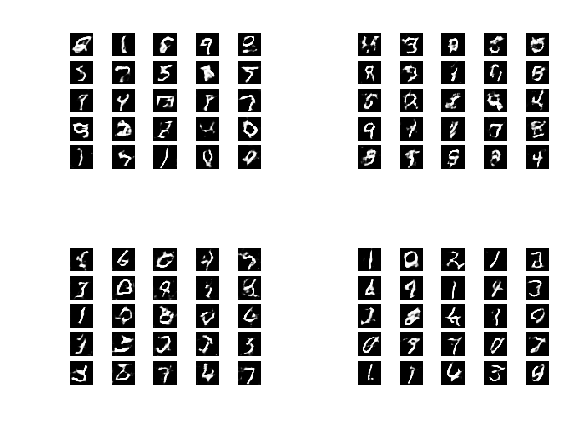

In [44]:
import matplotlib.image as mpimg
sides= 2
img_it= 0
for i in range(0, sides) :
    for j in range(0, sides) :
        img = mpimg.imread(list[img_it])
        plt.subplot(sides, sides, 1 + img_it)
        plt.axis("off")
        img_it +=1
        plt.imshow(img )
        
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()  

(-0.5, 575.5, 395.5, -0.5)

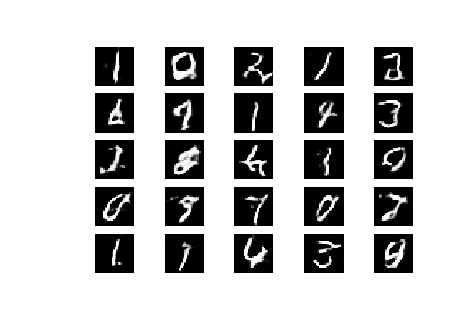

In [42]:

imgi =mpimg.imread('mnist_300.png')

imgplot = plt.imshow(img)

plt.axis("off")